In [1]:
# !pip install pycocotools
# !pip install tqdm

In [2]:
from pycocotools.coco import COCO

import os
import numpy as np
import random
import string
import time

import skimage.io as io
import matplotlib.pyplot as plt
from PIL import Image

from tqdm.notebook import tqdm

import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu

# 1. Exploring MS-COCO dataset

In [3]:
# initialize COCO api for training instance annotations
coco_train = COCO('data/annotations/instances_train2014.json')

# initialize COCO api for caption annotations
coco_train_caps = COCO('data/annotations/captions_train2014.json')

loading annotations into memory...
Done (t=11.86s)
creating index...
index created!
loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


In [4]:
# initialize COCO api for validation instance annotations
coco_val = COCO('data/annotations/instances_val2014.json')

# initialize COCO api for caption annotations
coco_val_caps = COCO('data/annotations/captions_val2014.json')

loading annotations into memory...
Done (t=6.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [5]:
# display COCO categories and supercategories
cats = coco_train.loadCats(coco_train.getCatIds())
cat_names = [cat['name'] for cat in cats]
print('COCO categories: \n{}'.format(', '.join(cat_names)))
print('Total: {}\n'.format(len(cat_names)))

supcat_names = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(', '.join(supcat_names)))
print('Total: {}'.format(len(supcat_names)))

COCO categories: 
person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush
Total: 80

COCO supercategories: 
person, outdoor, animal, kitchen, furniture, indoor, food, vehicle, sports, electronic, appliance, accessory
Total: 12


In [6]:
# count number of images in each category
nums = {}
for name in cat_names:
    cat_ids = coco_train.getCatIds(catNms=name)
    img_ids = coco_train.getImgIds(catIds=cat_ids)
    nums[name] = len(img_ids)
sorted_nums = dict(sorted(nums.items(), key=lambda item: item[1], reverse=True))
print(sorted_nums)

{'person': 45174, 'chair': 8950, 'car': 8606, 'dining table': 8378, 'cup': 6518, 'bottle': 5968, 'bowl': 5028, 'handbag': 4861, 'truck': 4321, 'backpack': 3924, 'bench': 3844, 'book': 3734, 'cell phone': 3322, 'sink': 3291, 'tv': 3191, 'couch': 3170, 'clock': 3159, 'knife': 3097, 'potted plant': 3084, 'dog': 3041, 'sports ball': 2986, 'traffic light': 2893, 'cat': 2818, 'bus': 2791, 'umbrella': 2749, 'tie': 2667, 'bed': 2539, 'fork': 2537, 'vase': 2530, 'skateboard': 2511, 'spoon': 2493, 'laptop': 2475, 'train': 2464, 'motorcycle': 2442, 'tennis racket': 2368, 'surfboard': 2343, 'toilet': 2317, 'bicycle': 2287, 'airplane': 2243, 'bird': 2241, 'skis': 2209, 'pizza': 2202, 'remote': 2180, 'boat': 2098, 'cake': 2080, 'horse': 2068, 'oven': 2003, 'baseball glove': 1884, 'baseball bat': 1804, 'giraffe': 1798, 'wine glass': 1771, 'refrigerator': 1671, 'sandwich': 1645, 'suitcase': 1631, 'kite': 1625, 'banana': 1618, 'elephant': 1518, 'frisbee': 1511, 'keyboard': 1471, 'cow': 1389, 'broccoli'

# 2. Selecting 5 categories

In [7]:
# select 5 categories
selected_cats = ['cat','dog','horse','bird','cow']

train_cat_ids = coco_train.getCatIds(catNms=selected_cats)
train_img_ids = [img_id
          for ids in (coco_train.getImgIds(catIds=cat_id) for cat_id in train_cat_ids)
          for img_id in ids]
train_img_ids = list(set(train_img_ids))
print('Total in selected categories in train:', len(train_img_ids))

val_cat_ids = coco_val.getCatIds(catNms=selected_cats)
val_img_ids = [img_id
          for ids in (coco_val.getImgIds(catIds=cat_id) for cat_id in val_cat_ids)
          for img_id in ids]
val_img_ids = list(set(val_img_ids))
print('Total in selected categories in val:', len(val_img_ids))

Total in selected categories in train: 11021
Total in selected categories in val: 5526


COCO_train2014_000000493316.jpg 

A cat peeking out of a suit case.
A black and white cat is hiding in a bag.
A black and white cat laying inside of a black piece of luggage.
A black and white cat with its face partially covered
A black and white cat peeking out of something. 


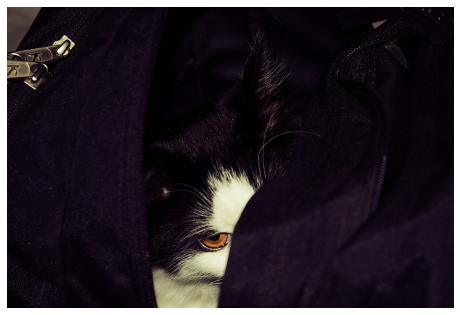

In [8]:
# show random image from train and its captions
img = coco_train.loadImgs(train_img_ids[np.random.randint(0, len(train_img_ids))])[0]
I = io.imread('data/train2014/' + img['file_name'])

ann_ids = coco_train_caps.getAnnIds(imgIds=img['id'])
anns = coco_train_caps.loadAnns(ann_ids)

print(img['file_name'], '\n')
coco_train_caps.showAnns(anns)

plt.figure(figsize=(8,10))
plt.imshow(I)
plt.axis('off')
plt.show()

# 3. Creating dataset for image captioning task

In [8]:
def preprocess_caption(cap):
    cap = cap.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    cap = cap.replace("-"," ") # replace - to blank
    cap = cap.split() # split string into word list
    cap = [word.lower() for word in cap] # convert each word into lower case     
    cap = '<start> ' + " ".join(cap) + ' <end>' # join word list into sentence with <start> and <end> tags 
    return cap

def create_data_vectors(img_ids, coco, coco_caps, data_path):
    captions = []
    img_paths = []
    for img_id in img_ids:
        img = coco.loadImgs(img_id)[0]
        ann_ids = coco_caps.getAnnIds(imgIds=img['id'])
        anns = coco_caps.loadAnns(ann_ids)
        for cap in anns:
            cap = preprocess_caption(cap['caption'])
            captions.append(cap)
            img_paths.append(data_path + img['file_name'])                      
    return captions, img_paths

caps_train, imgs_train = create_data_vectors(train_img_ids, coco_train, coco_train_caps, 'data/train2014/')
caps_val, imgs_val = create_data_vectors(val_img_ids, coco_val, coco_val_caps, 'data/val2014/')

print("Length of train dataset:", len(caps_train))
print("Length of validation dataset:", len(caps_val))

Length of train dataset: 55130
Length of validation dataset: 27646


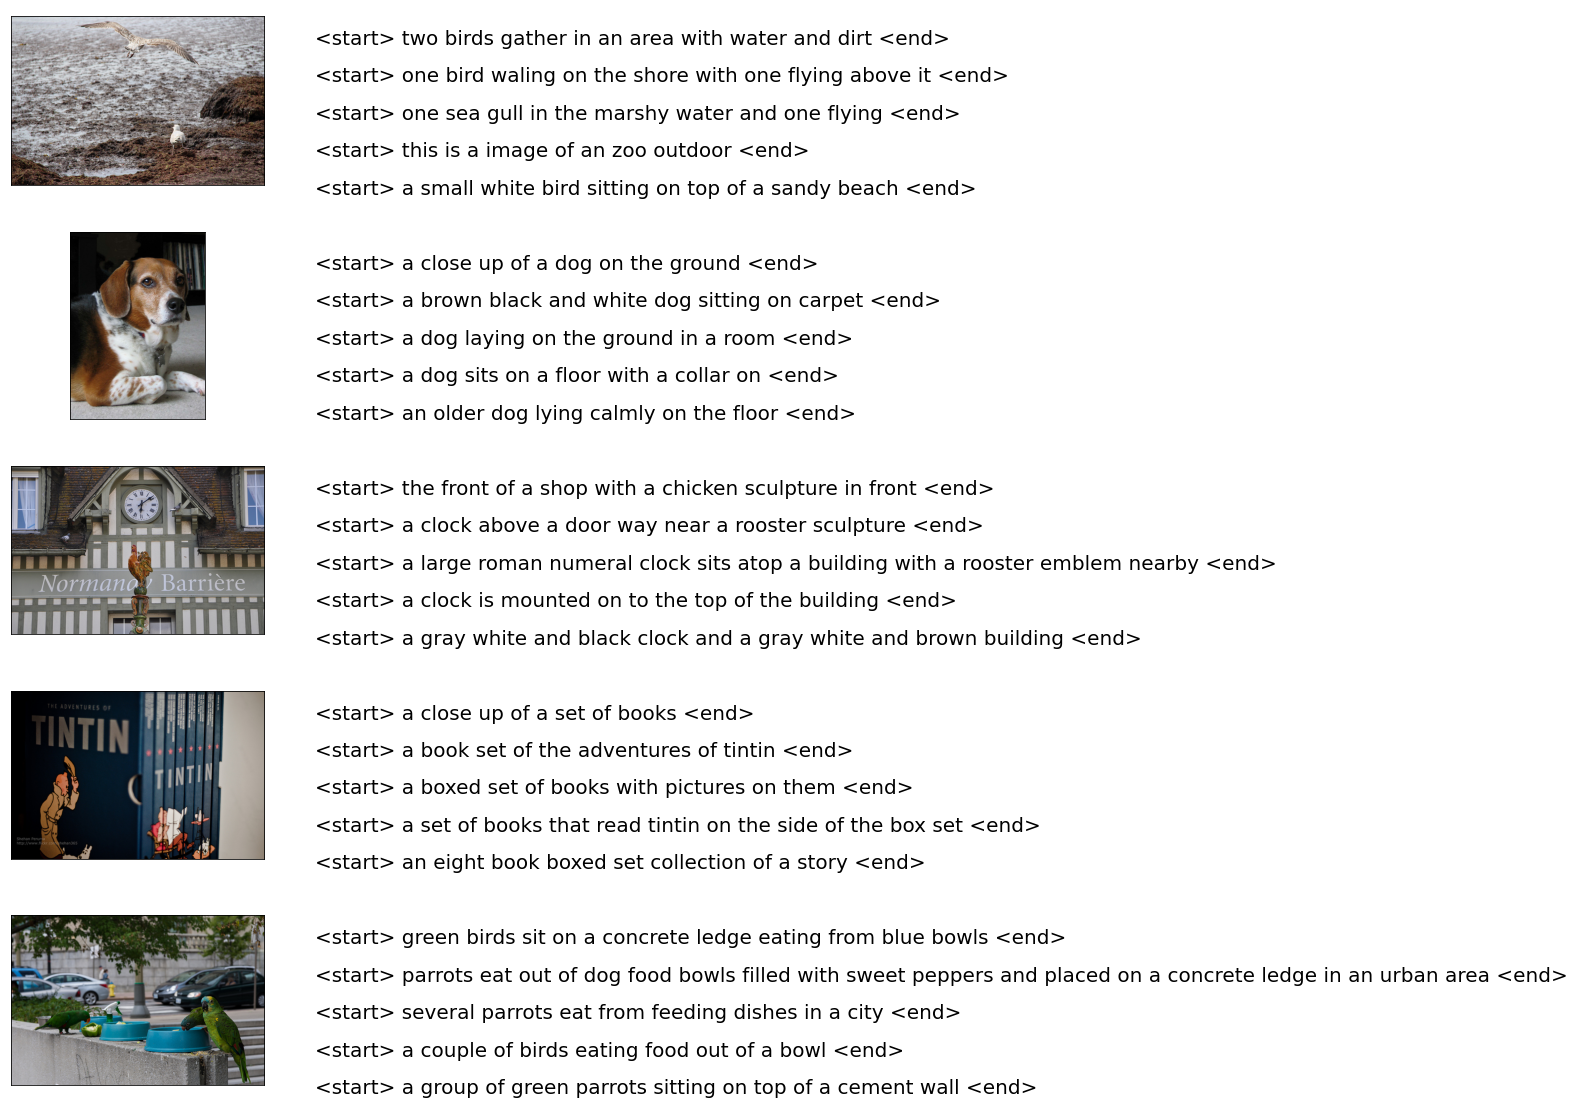

In [9]:
# show some random images from train and their preprocessed captions
img_num = 5
count = 1

fig = plt.figure(figsize=(10,20))
for img_path in random.sample(list(set(imgs_train)), img_num):
    img_indices = [i for i, x in enumerate(imgs_train) if x == img_path]
    captions = [caps_train[i] for i in img_indices]
    image = io.imread(img_path)
    ax = fig.add_subplot(img_num, 2, count, xticks=[], yticks=[])
    ax.imshow(image)
    count += 1

    ax = fig.add_subplot(img_num, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    count += 1
plt.show()

# 4. Tokenizing captions

In [9]:
# make a vocabulary of all of the unique words in the training data 
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<oov>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(caps_train)

seqs_train = tokenizer.texts_to_sequences(caps_train)

total_words = len(tokenizer.word_index) + 1
print("Vocabulary length: ", total_words)

Vocabulary length:  8471


In [10]:
# pad captions which are naturally of varying length to the same length with <pad> tokens
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

seqs_train = tf.keras.preprocessing.sequence.pad_sequences(seqs_train, padding='post')

print("Sequence length:", len(seqs_train[0]))

Sequence length: 51


In [11]:
# tokenize validation captions
seqs_val = tokenizer.texts_to_sequences(caps_val)
seqs_val = tf.keras.preprocessing.sequence.pad_sequences(seqs_val, padding='post')

# 5. Creating image features extraction model

In [12]:
# we will use transfer learning for image features extraction
model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
image_features_extract_model = tf.keras.Model(model.input, model.layers[-1].output)

# 6. Extracting features from train and validation images

In [13]:
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [14]:
# create set of all preprocessed train images and their paths
batch_size = 64
image_dataset = tf.data.Dataset.from_tensor_slices(sorted(set(imgs_train + imgs_val)))
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

In [ ]:
# extract features from all train and validation images and store them on disk
os.makedirs('data/features/')
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img) # shape=(batch_size, 8, 8, 2048)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3])) # shape=(batch_size, 64, 2048)
    for bf, p in zip(batch_features, path):
        # write each image features in separate numpy file
        file_path = p.numpy().decode("utf-8")
        np.save('data/features/' + file_path.split('/')[-1], bf.numpy())

# 7. Defining captioning model structure

In [15]:
# passes image features through a fully connected layer
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x) # shape=(batch_size, 64, embedding_dim)
        x = tf.nn.relu(x)
        return x

In [16]:
class LocalAttention(tf.keras.Model):
    def __init__(self, units):
        super(LocalAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # shape=(batch_size, 1, hidden_size)
        
        # the bahdanau soft attention mechanism
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.attention = LocalAttention(self.units)
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, hidden):
        context_vector = self.attention(features, hidden)
        
        x = self.embedding(x)
        
        # concatenate weighted image features and predicted token embeddings
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
                      
        output, state = self.gru(x)
                      
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

# 8. Training captioning model

In [17]:
# training parameters
batch_size = 64
buffer_size = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
max_seq_length = len(seqs_train[0])
num_steps = len(imgs_train) // batch_size
val_num_steps = len(imgs_val) // batch_size

# shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048 
attention_features_shape = 64

In [18]:
# load images features from files
def load_features(img_path, cap):
    file_path = img_path.decode("utf-8")
    img_tensor = np.load('data/features/' + file_path.split('/')[-1] + '.npy')
    return img_tensor, cap

def create_dataset(imgs, seqs):
    dataset = tf.data.Dataset.from_tensor_slices((imgs, seqs))

    # use map to load files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_features, [item1, item2], [tf.float32, tf.int32]),
              num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # shuffle and batch dataset
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [19]:
# create training and validation datasets
train_dataset = create_dataset(imgs_train, seqs_train)
val_dataset = create_dataset(imgs_val, seqs_val)

In [20]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [22]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state and initial word for each image in batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    # calculate the gradients, apply it to the optimizer and backpropagate
    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

@tf.function
def validate_epoch(img_tensor, target):
    loss = 0

    # initializing the hidden state and initial word for each batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        # passing the features through the decoder
        predictions, hidden = decoder(dec_input, features, hidden)

        loss += loss_function(target[:, i], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(target[:, i], 1)

    # calculate validation loss
    total_loss = (loss / int(target.shape[1]))
    return total_loss

In [23]:
epochs = 20
loss_plot = []
val_loss_plot = []

for epoch in range(0, epochs):
    start = time.time()
    total_loss = 0
    val_total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Batch loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing loss value to plot later
    loss_plot.append(total_loss / num_steps)
    
    # calculating validation loss
    for (val_batch, (val_img_tensor, val_target)) in enumerate(val_dataset):
        val_total_loss += validate_epoch(val_img_tensor, val_target)

    # storing loss value to plot later
    val_loss_plot.append(val_total_loss / val_num_steps)
    
    print ('Epoch {} Train loss {:.6f} Val loss {:.6f}'.format(epoch + 1, total_loss / num_steps, val_total_loss / val_num_steps))
    print ('Time taken for epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Batch loss 2.0158
Epoch 1 Batch 100 Batch loss 1.0683
Epoch 1 Batch 200 Batch loss 0.9617
Epoch 1 Batch 300 Batch loss 0.7312
Epoch 1 Batch 400 Batch loss 0.7717
Epoch 1 Batch 500 Batch loss 0.7542
Epoch 1 Batch 600 Batch loss 0.6460
Epoch 1 Batch 700 Batch loss 0.7004
Epoch 1 Batch 800 Batch loss 0.7137
Epoch 1 Train loss 0.817734 Val loss 0.708177
Time taken for epoch 2161.7747905254364 sec

Epoch 2 Batch 0 Batch loss 0.7095
Epoch 2 Batch 100 Batch loss 0.6990
Epoch 2 Batch 200 Batch loss 0.7010
Epoch 2 Batch 300 Batch loss 0.7085
Epoch 2 Batch 400 Batch loss 0.6957
Epoch 2 Batch 500 Batch loss 0.6739
Epoch 2 Batch 600 Batch loss 0.6433
Epoch 2 Batch 700 Batch loss 0.5914
Epoch 2 Batch 800 Batch loss 0.6318
Epoch 2 Train loss 0.646593 Val loss 0.672448
Time taken for epoch 2380.389770269394 sec

Epoch 3 Batch 0 Batch loss 0.6444
Epoch 3 Batch 100 Batch loss 0.5912
Epoch 3 Batch 200 Batch loss 0.6112
Epoch 3 Batch 300 Batch loss 0.5834
Epoch 3 Batch 400 Batch loss 0.60

Epoch 20 Batch 800 Batch loss 0.2802
Epoch 20 Train loss 0.296540 Val loss 0.924473
Time taken for epoch 2775.187697649002 sec



In [58]:
rev = val_loss_plot[::-1]

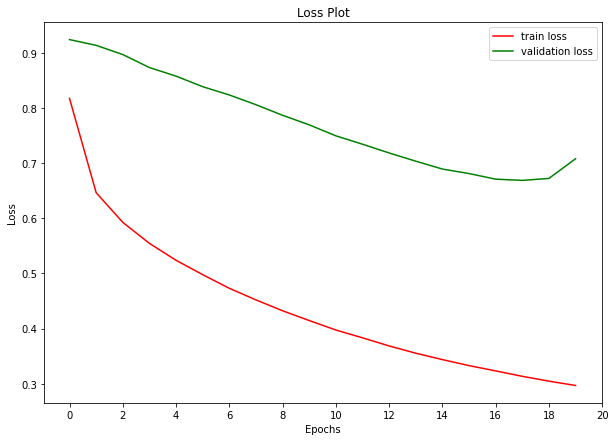

In [92]:
# create loss plot
plt.figure(figsize=(10,7))
plt.plot(loss_plot, color='red')
plt.plot(rev, color='green')

plt.legend(['train loss', 'validation loss']) 
plt.xticks(np.arange(0, 21, step=2))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')

plt.show()

In [25]:
encoder.save_weights('encoder_weights.h5')
decoder.save_weights('decoder_weights.h5')

# 9. Create image captioning function and evaluating model

In [ ]:
# encoder.load_weights('encoder_weights.h5')
# decoder.load_weights('decoder_weights.h5')

In [116]:
# prediction function
def caption(image):
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_seq_length):
        predictions, hidden = decoder(dec_input, features, hidden)

        # using greedy search for defining next word
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])
        
        if tokenizer.index_word[predicted_id] == '<end>':
            result = ' '.join(result)
            return result

        dec_input = tf.expand_dims([predicted_id], 0)
        
    result = ' '.join(result)
    return result

In [117]:
def evaluate_val_image_captioning(image):
    img_val_indices = [i for i, x in enumerate(imgs_val) if x == image]
    # get real captions and remove <start> and <end> from them
    real_captions = [(caps_val[i].split(' ', 1)[1]).rsplit(' ', 1)[0] for i in img_val_indices]

    prediction = caption(image)
    if (prediction.rsplit(' ', 1)[1] == '<end>'): # remove <end> tag
        prediction = prediction.rsplit(' ', 1)[0]
    
    bleu_score = sentence_bleu(real_captions, prediction) * 100
    return real_captions, prediction, bleu_score

Real Captions:
a large black dog sitting in a room
a black dog looking straight ahead in the kitchen
a black dog with a red collar standing in a kitchen
a dog that is sitting down on the floor
a black dog wearing a collar and sitting on the floor

Predicted Caption:
a large black dog that is sitting on the floor

BLEU score: 93.16150321436716


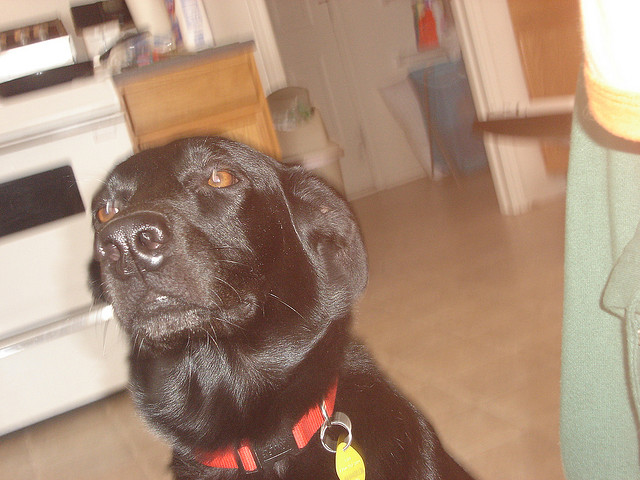

In [50]:
# test captioning on random image from the validation set
rid = np.random.randint(0, len(imgs_val))
image = imgs_val[rid]

real_captions, prediction, bleu_score = evaluate_val_image_captioning(image)

print ('Real Captions:')
for cap in real_captions:
    print(cap)
print ('\nPredicted Caption:')
print(prediction)
print('\nBLEU score:', bleu_score)
Image.open(image)

Real Captions:
a black and white dog is looking out of a window from inside a house
the dog is looking at something out of the window
a dog looking outside through the window while standing
a dog is staring intently out the window
a dog standing by a window looking outside for something

Predicted Caption:
a dog is standing against a window

BLEU score: 70.03152218517616


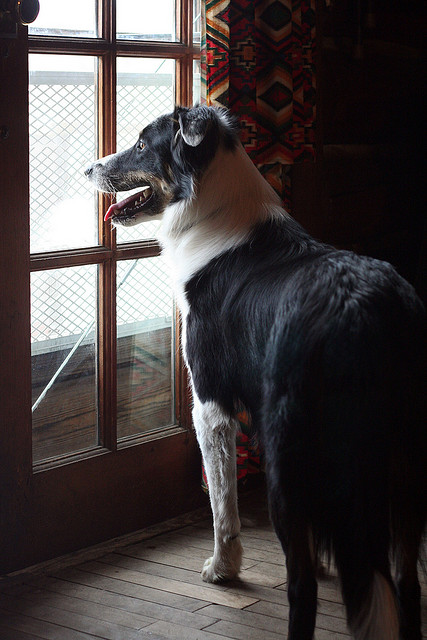

In [51]:
# test captioning on random image from the validation set
rid = np.random.randint(0, len(imgs_val))
image = imgs_val[rid]

real_captions, prediction, bleu_score = evaluate_val_image_captioning(image)

print ('Real Captions:')
for cap in real_captions:
    print(cap)
print ('\nPredicted Caption:')
print(prediction)
print('\nBLEU score:', bleu_score)
Image.open(image)

Real Captions:
a cat laying on top of a table in front of a mirror
cat lying on cabinet looking a photographer in a mirror
the cat admires its reflection in the mirror
a cat lays on a table staring at the camera through a mirror
a cat laying in front or a large ornate mirror

Predicted Caption:
a cat laying on top of a round mirror

BLEU score: 72.25121171740697


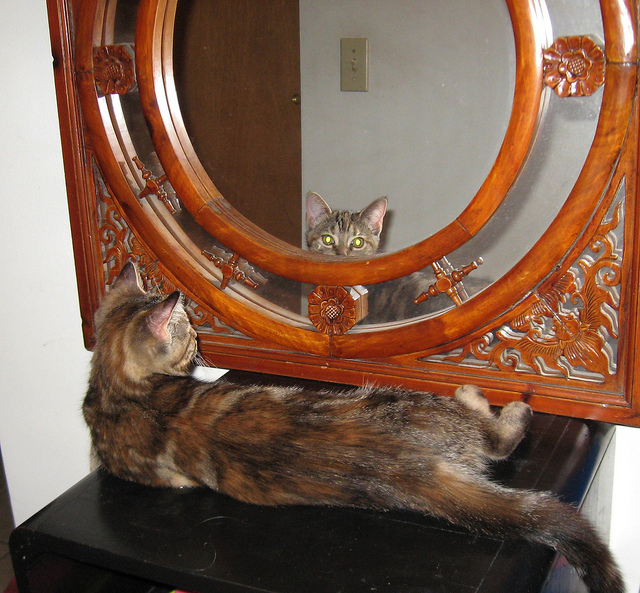

In [62]:
# test captioning on random image from the validation set
rid = np.random.randint(0, len(imgs_val))
image = imgs_val[rid]

real_captions, prediction, bleu_score = evaluate_val_image_captioning(image)

print ('Real Captions:')
for cap in real_captions:
    print(cap)
print ('\nPredicted Caption:')
print(prediction)
print('\nBLEU score:', bleu_score)
Image.open(image)

Real Captions:
a bird is standing on the small branch outside
a bird sits on top of branches with fruit
a bird stands on a branch next to some fruit
a red white and black bird in tree with fruit on it
small black bird with red on its head standing on a tree branch

Predicted Caption:
a small bird looking at fruit tree

BLEU score: 57.564005051985426


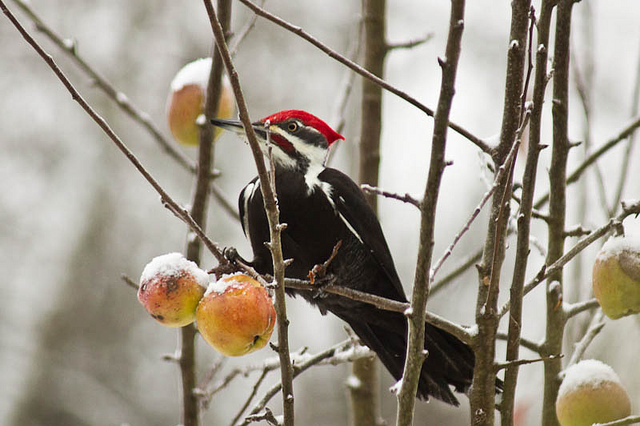

In [86]:
# test captioning on random image from the validation set
rid = np.random.randint(0, len(imgs_val))
image = imgs_val[rid]

real_captions, prediction, bleu_score = evaluate_val_image_captioning(image)

print ('Real Captions:')
for cap in real_captions:
    print(cap)
print ('\nPredicted Caption:')
print(prediction)
print('\nBLEU score:', bleu_score)
Image.open(image)

Real Captions:
the boats navigated around the curves of the attraction
a few empty boats at a river ride
small boats sit unused in water by a dock
different color boats along a river in a water park
a multicolored boat ride at an amusement park

Predicted Caption:
a dock sitting on a dock

BLEU score: 37.39752241903388


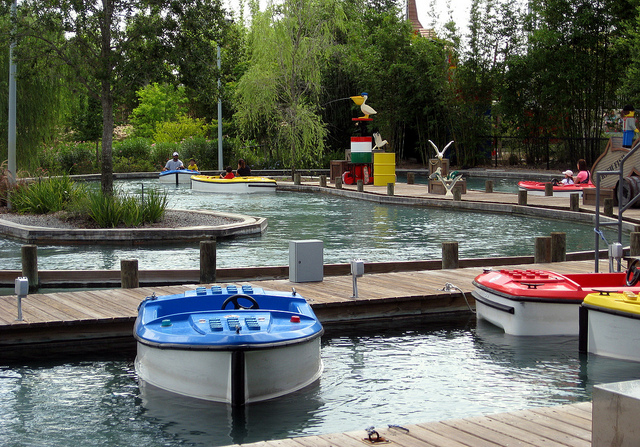

In [90]:
# test captioning on random image from the validation set
rid = np.random.randint(0, len(imgs_val))
image = imgs_val[rid]

real_captions, prediction, bleu_score = evaluate_val_image_captioning(image)

print ('Real Captions:')
for cap in real_captions:
    print(cap)
print ('\nPredicted Caption:')
print(prediction)
print('\nBLEU score:', bleu_score)
Image.open(image)

In [76]:
 # calculating mean BLEU for img_num random image from the validation set
img_num = 100
total_bleu = 0
for image in tqdm(random.sample(list(set(imgs_val)), img_num)):
    _, _, bleu_score = evaluate_val_image_captioning(image)
    total_bleu += bleu_score
print('Mean BLEU score on', img_num, 'images from validation set:', total_bleu / img_num)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean BLEU score on 100 images from validation set: 49.32074148054313


In [ ]:
# calculating mean BLEU on the whole validation set 
total_bleu = 0 
for image in tqdm(list(set(imgs_val))): 
    _, _, bleu_score = evaluate_val_image_captioning(image) 
    total_bleu += bleu_score 
print('Mean BLEU score on whole validation set:', total_bleu / len(list(set(imgs_val)))) 

Mean BLEU score on whole validation set: 49.02240164439296


Real Captions:
a lone brown cow stands on an empty beach
an animal stands on the beach in front of the ocean
a large yak is standing alone on a beach
a bison standing on a beach near the shore
a bull standing in the sand at the beach

Predicted Caption:
a cow is lying on a beach

BLEU score: 44.471602652705464


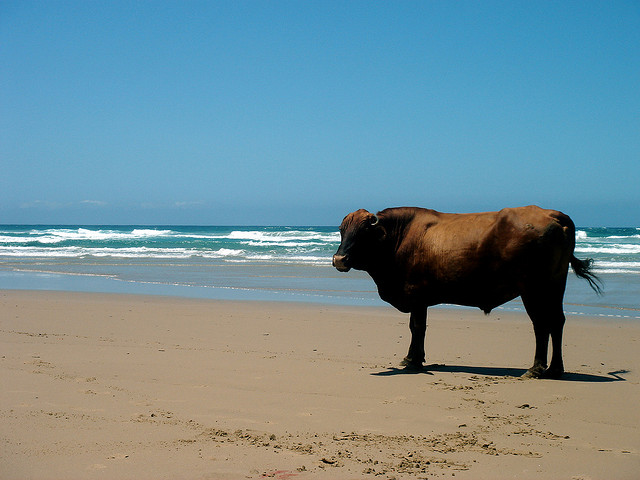

In [118]:
# test captioning on random image from the validation set
rid = np.random.randint(0, len(imgs_val))
image = imgs_val[rid]

real_captions, prediction, bleu_score = evaluate_val_image_captioning(image)

print ('Real Captions:')
for cap in real_captions:
    print(cap)
print ('\nPredicted Caption:')
print(prediction)
print('\nBLEU score:', bleu_score)
Image.open(image)

Real Captions:
a cop riding on the back of a brown horse down a street
a man riding a brown horse in the street
a police officer is riding a horse down the street
an officer is on a large brown horse as a man with a bike is next to them
a street with a police officer riding a horse in front of storefronts and pedestrians on the street

Predicted Caption:
a man riding a horse on a street

BLEU score: 76.50112487651512


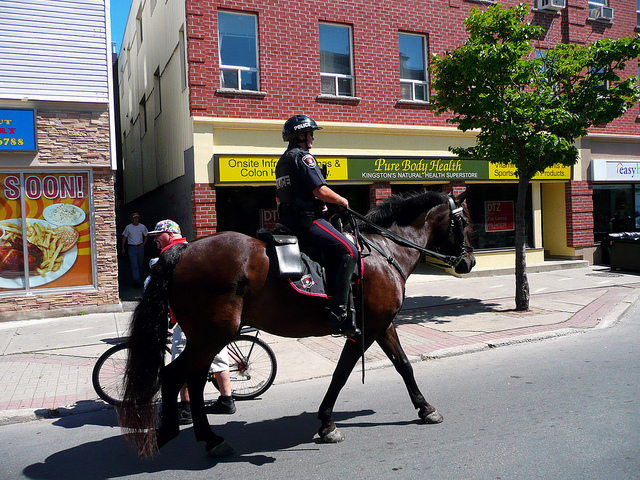

In [119]:
# test captioning on random image from the validation set
rid = np.random.randint(0, len(imgs_val))
image = imgs_val[rid]

real_captions, prediction, bleu_score = evaluate_val_image_captioning(image)

print ('Real Captions:')
for cap in real_captions:
    print(cap)
print ('\nPredicted Caption:')
print(prediction)
print('\nBLEU score:', bleu_score)
Image.open(image)